## Importing necessary packages

In [1]:
# For environment API
import gym

# For model creation and training
import tensorflow as tf
from tensorflow.keras import layers

# Other utilities
import numpy as np
import random
import itertools

# tqdm for visualizing training progress
from tqdm import tqdm

# Data visualization and formatting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter

## Initializing environment, model, and defining functions

In [2]:
# Initialize Blackjack environment
# Blackjack-v1 is a prebuilt environment hosted by gym with simplified Blackjack mechanics
env = gym.make('Blackjack-v1')

# Parameters for the neural network
state_shape = (3,)  # State has 3 values: player sum, dealer card, usable ace
num_actions = env.action_space.n  # 2 actions: hit or stand

# Define [deep] Q-network
def create_q_network(state_shape, num_actions):
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=state_shape))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_actions, activation=None))  # No activation on output layer
    return model

# Replay Buffer
# As the model trains through several episodes, its memory of experiences grows in size
# A replay buffer prevents that memory from getting too large by dropping the oldest experiences when it reaches the maximum buffer size
# It also stabilizes the training process by randomly sampling batches from the experiences
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = []
        self.max_size = max_size

    def add(self, experience):
        if len(self.buffer) >= self.max_size:
            self.buffer.pop(0)
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

# Set the replay buffer to 5,000
replay_buffer = ReplayBuffer(max_size=5_000)

# Preprocess state function
# Converts the state to a numpy array
def preprocess_state(state):
    if len(state) == 3:
        player_sum = state[0]
        dealer_visible_card = state[1]
        usable_ace = state[2]
        
        return np.array([player_sum, dealer_visible_card, int(usable_ace)])
    else:
        return np.array([0, 0, 0])
    
# Loss function
# Mean squred error (MSE) formula
def compute_loss(q_values, target_q_values):
    return tf.reduce_mean(tf.square(q_values - target_q_values))

## Creating a set of test states to visualize policy later

In [3]:
# Create a list of possible states to test the model's policy
player_hand_totals = range(4, 21)  # Player hand totals from 4 to 20
dealer_hand_totals = range(1, 11)  # Dealer showing total from 1 to 10
usable_ace = [0, 1]  # 0 if no usable ace, 1 if there is a usable ace

# Generate all combinations
blackjack_states = list(itertools.product(player_hand_totals, dealer_hand_totals, usable_ace))

## Setting Training Parameters

In [4]:
# Initialize Q network
q_network = create_q_network(state_shape, num_actions)

# Initialize target Q network
# The reason for a Q network and separate "target" Q network is to stabilize the training process
target_q_network = create_q_network(state_shape, num_actions)
# Copy Q network weights to the target Q network
target_q_network.set_weights(q_network.get_weights())

# Initialize an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


# Number of games (episodes) to simulate
num_episodes = 25_000
# Number of games (episodes) to batch sample when calculating Q values
batch_size = 64
# Gamma determines how much the network should focus on future rewards vs immediate rewards.
# 0.99 is focusing on future rewards (winning the game overall)
gamma = 0.99
# Epsilon determines the initial exploration factor
# Epsilon of 1.0 means 100% chance of a random action in order to explore and understand the mechanics
epsilon = 1.0
# Epsilon decay determines how much epsilon will decrease with each episode. As epsilon decreaes, the agent's decisions shift from exploration to exploitation
# With a decay rate of 0.9998, it should reach the minimum epsilon after about 11,000 episodes, spending most of the remaining 14,000 episodes refining the learned policy
epsilon_decay = 0.9998
# Minimum epsilon - epsilon will decrease with each episode, but should bottom out at this level (0.1)
epsilon_min = 0.1

# Logging reward rates for visualizing training progress
log_interval = 50 # How many episodes between logging win rate
rewards_interval = 0
reward_rates = []

## Training Loop

In [5]:
# Running the training process to simulate 25,000 games
for episode in tqdm(range(num_episodes), ncols=200):
    # Resets the game state
    state = preprocess_state(env.reset())
    done = False
    total_reward = 0

    # Game simulation runs until the environment determines that it is 'done', for example a player busting or both dealer & player standing
    while not done:
        # Epsilon-greedy policy
        # Randomly choose an action, if another random number between 0 and 1 falls below the epsilon value
        if np.random.rand() < epsilon:
            action = np.random.randint(num_actions)
        
        # Otherwise, choose an action based on the highest Q value for that state
        else:
            q_values = q_network.predict(state[np.newaxis], verbose=False)
            action = np.argmax(q_values[0])

        # Get the new state after the action is performed (e.g. another card is dealt after choosing 'hit')
        # Last 2 elements of the state aren't used
        next_state, reward, done, _, _ = env.step(action)
        next_state = preprocess_state(next_state)

        # Add the experience to the replay buffer
        replay_buffer.add((state, action, reward, next_state, done))

        # Make the new state the current state
        state = next_state

        # Add (or subtract, if negative) the resulting reward
        total_reward += reward

        # If there are more experiences in the buffer than the batch size...
        if len(replay_buffer.buffer) > batch_size:
            # Get a random sample of experiences
            batch = replay_buffer.sample(batch_size)
            # Breaks the sample experiences into each component, and maps them to a numpy array
            states, actions, rewards, next_states, dones = map(np.array, zip(*batch))

            # Predicts the Q values for 'hit' and 'stand' for all next states
            next_q_values = target_q_network.predict(next_states, verbose=False)
            # Gets the highest Q value for each each of the next states
            max_next_q_values = np.max(next_q_values, axis=1)

            # Computes the target Q values
            target_qs = rewards + (1 - dones) * gamma * max_next_q_values

            # Loss calculation and backpropagation
            # All computations in this block are recorder for later backpropagation
            with tf.GradientTape() as tape:
                q_values = q_network(states)
                # Creates one-hot vectors for each action in the batch
                # By multiplying the Q-values with these one-hot encoded action vectors and summing, we extract the Q-value for each state-action pair taken in the experience
                q_values = tf.reduce_sum(q_values * tf.one_hot(actions, num_actions), axis=1)
                # Compute loss
                loss = compute_loss(q_values, target_qs)

            # Computes gradients
            # Gradients indicate the direction in which each weight should change to reduce the loss
            grads = tape.gradient(loss, q_network.trainable_variables)
            # Applies gradients to the Q network using the optimizer
            optimizer.apply_gradients(zip(grads, q_network.trainable_variables))

    # Epsilon value decays at the specified rate, but goes no lower than the minimum epsilon value
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Track rewards
    rewards_interval += total_reward

    # Log win rate every 'log_interval' episodes
    if (episode + 1) % log_interval == 0:
        reward_ratio = rewards_interval / log_interval
        reward_rates.append(reward_ratio)
        #print(f"Episode {episode + 1}: Win rate: {win_rate:.2f}%")
        # Reset counters
        rewards_interval = 0

    # Every 10 episodes, update the target Q network's weights
    if episode % 10 == 0:
        target_q_network.set_weights(q_network.get_weights())

    # Every 500 episodes, create a plot showing how the current policy would handle a set of possible game states
    if (episode + 1) % 500 == 0:
        # Create separate charts for the 'with usable ace' and 'without usable ace' states
        for d in [0,1]:
            bot_hand = []
            dealer_hand = []
            action_list = []
            # Have the model determine the best option in each state in the range of states
            for state in blackjack_states:
                if state[2] == d:
                    bot_hand.append(state[0])
                    dealer_hand.append(state[1])
                    q_values = target_q_network.predict(np.array(state)[np.newaxis], verbose=False)
                    action = np.argmax(q_values[0])
                    action_list.append(action)
            # Create a pivot table in pandas that will be used for a heatmap        
            df = pd.DataFrame({'x': bot_hand, 'y': dealer_hand, 'action': action_list})
            heatmap_data = df.pivot(index='x', columns='y', values='action')

            # Plot the heatmap
            plt.figure(figsize=(12, 8))
            sns.heatmap(heatmap_data, cmap="winter", annot=True, cbar=False)
            plt.xlabel('Dealer Showing')
            plt.ylabel('Player Hand Total')
            # Save to different directories
            if d == 0:
                plt.savefig(f"policy_without_ace/{episode}_noace.jpg", format='jpg', dpi=300, bbox_inches='tight')
            else:
                plt.savefig(f"policy_with_ace/{episode}_ace.jpg", format='jpg', dpi=300, bbox_inches='tight')
            # Close plot to avoid excess memory usage
            plt.close()

  0%|                                                                                                                                                                         | 0/25000 [00:00<?, ?it/s]c:\Users\Alex School\.conda\envs\ml_3_10\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [44:13<00:00,  9.42it/s]


## Persist Model

In [ ]:
# Compile and save the model/bot
target_q_network.compile(optimizer=optimizer, loss=None)
target_q_network.save('blackjack_bot_25000epochs_v2.h5')

## Visualizing the model's learning

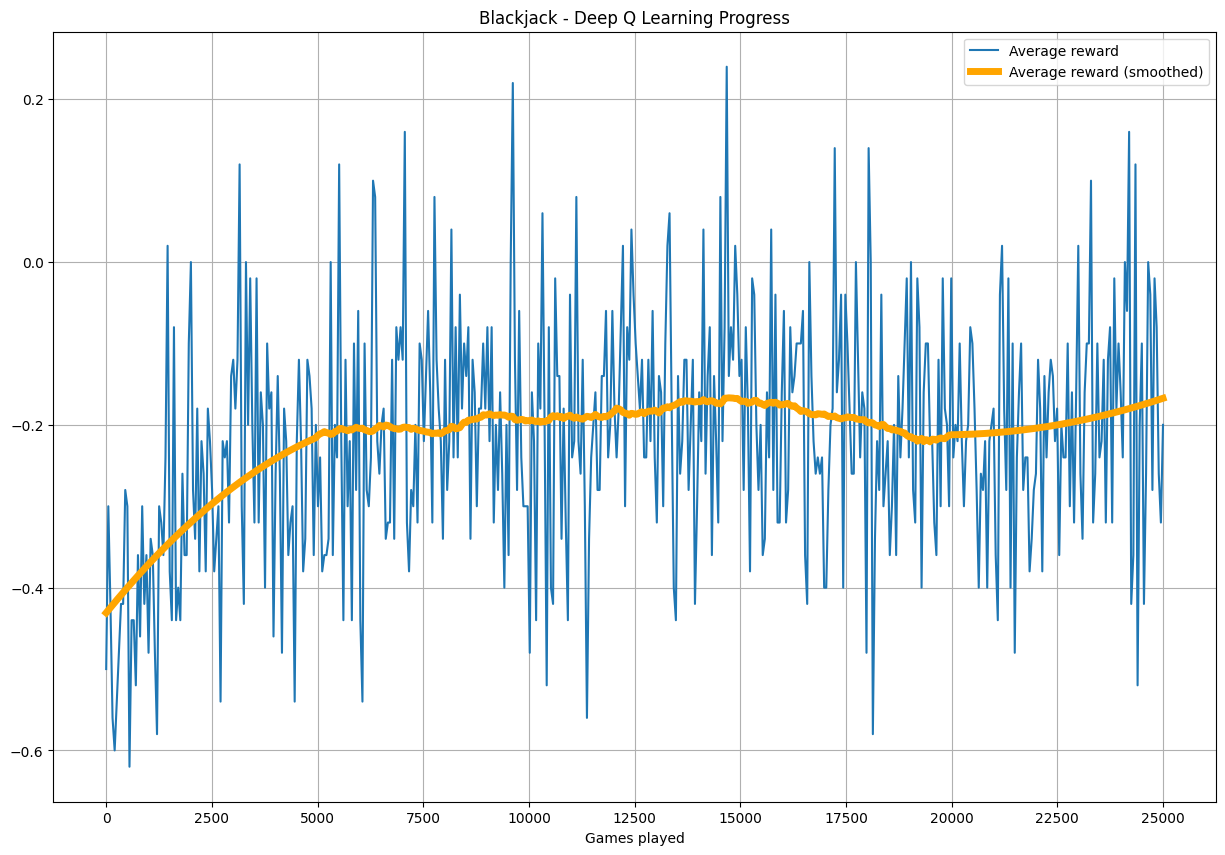

In [12]:
# Apply Savitzky-Golay filter to create smooth line
smooth_reward_rates = savgol_filter(reward_rates, window_length=200, polyorder=2)

# Create plot
plt.figure(figsize=(15, 10))
sns.lineplot(x=range(len(reward_rates)), y=reward_rates, label='Average reward')
sns.lineplot(x=range(len(smooth_reward_rates)), y=smooth_reward_rates, color="orange", label='Average reward (smoothed)', linewidth=5)

# Make modifications for readability
plt.xticks(ticks=np.linspace(0, len(reward_rates)-1, 11), labels=np.linspace(0, num_episodes, 11, dtype=int))
plt.xlabel('Games played')
plt.legend()
plt.title('Blackjack - Deep Q Learning Progress')
plt.grid()
plt.show()


What seems a bit underwhelming is that the bot's average reward is negative, meaning it loses more than half the time even at its best.  
This should not be too surprising, though, because it is still largely a game of chance with the odds being in the house's favor.  
What this still demonstrates is that reinforcement learning was able to teach a machine how to avoid most of the obvious mistakes.  